# Remote Sensing for N - predictions 
    - In the RemoteSensingPredictions1( last date only) and 2 (Split) we settled on the best method to model and predict.
    - Random split of R2 and R4 data which is heavily biased towards R2 - SVR using features : MS indexes - Time point information - Canopy STD from Point Cloud - and field counted TotalLeaves
        [  'NDVI', 'GDD_Encode', 'STD', 'TotalLeaves', 'GNDVI', 'MSR', 'NDI', 'NDVIRedge', 'PSRI', 'CIRedge', 'MTCI']
    - 

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import pingouin as pg
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# set seed for torch and other ML functions
np.random.seed(42)

# sns set activates a nicer display for seaborn graphs
sns.set()

In [2]:
# Load data
df1 = pd.read_csv(r'Data/16Hybrids_3yearsRaw.csv')
df2 = pd.read_csv(r'Data/HIPS2020_Ht_RGB.csv')
df3 = pd.read_csv(r'Data/HIPS2020_Reflectance.csv')
df4 = pd.read_csv(r'Data/MSU2020_LeafNutrient.csv')

c:\Users\bdub\AppData\Local\Programs\Python\Python311\Lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
# Prepare data
dfs = [df1, df2, df3, df4]
for df in dfs:
    df['Plot'] = df['Plot'].astype('str')

df_field = df1[df1['Year'] == 2020]

df_ref = df3[df3['Band'].isin(['Red', 'NIR', 'Green', 'RedEdge', 'Blue', 'SAVIMASK'])]
df_ref = df_ref.loc[:, ['ID', 'Plot', 'MEAN', 'STD', 'Date', 'Band']]

In [4]:
# Calculate indices
# Calculate NDVI
unmelt = df_ref.pivot(index='ID', columns = 'Band', values= 'MEAN').reset_index()
# Just doing this here to move it down later
unmelt['NDVI'] = (unmelt['NIR'] - unmelt['Red']) / (unmelt['NIR'] + unmelt['Red'])
unmelt['GNDVI'] = (unmelt['NIR'] - unmelt['Green']) / (unmelt['NIR'] + unmelt['Green'])
unmelt['RDVI'] = (unmelt['NIR'] - unmelt['Red']) / (np.sqrt(unmelt['NIR'] + unmelt['Red']))
unmelt['NLI'] = ((unmelt['NIR']**2) - unmelt['Red']) / ((unmelt['NIR']**2) + unmelt['Red'])
unmelt['CVI'] = (unmelt['NIR'] * unmelt['NIR']) / (unmelt['Green']**2)
unmelt['MSR'] = ((unmelt['NIR'] / unmelt['Red']) - 1) / ((np.sqrt(unmelt['NIR'] / unmelt['Red'])) + 1)
unmelt['NDI'] = (unmelt['RedEdge'] - unmelt['Red']) / (unmelt['RedEdge'] + unmelt['Red'])
unmelt['NDVIRedge'] = (unmelt['NIR'] - unmelt['RedEdge']) / (unmelt['NIR'] + unmelt['RedEdge'])
unmelt['PSRI'] = (unmelt['Red'] - unmelt['Blue']) / unmelt['RedEdge']
unmelt['CIRedge'] = (unmelt['NIR'] / unmelt['RedEdge']) - 1
unmelt['MTCI'] = (unmelt['NIR'] - unmelt['RedEdge']) / (unmelt['RedEdge'] - unmelt['Red'])


In [5]:
# To split a string into 2 new columns have to limit split to 1 split and set expand = T parameter. 
unmelt[['Plot', 'GDD']] = unmelt['ID'].str.split(pat = '_',n = 1, expand = True)
unmelt['GDD'] = unmelt['GDD'].astype('int')
df_m = pd.merge(unmelt, df_field, on = 'Plot')
# Create a df df_pcmn - point cloud, merged nutrients that contains All data 
meta = list(df_field.columns)
meta.append('GDD')
df_refm = pd.merge(df_field, unmelt, on = 'Plot', how = 'inner')
df_pcm = pd.merge(df_field, df2, on = 'Plot', how = 'inner')
df4x = df4.loc[:, ['Plot', 'GDD', 'N(%)', 'S(%)', 'P(%)', 'K(%)', 'Mg(%)', 'Ca(%)', 'Fe(ppm)', 'Al(ppm)', 'Mn(ppm)', 'Cu(ppm)', 'Zn(ppm)', 'B(ppm)']]
df_nm = pd.merge(df_field, df4x, on= 'Plot', how = 'inner')

df_npcr = pd.merge(df_refm, df_pcm, on = meta, how = 'outer')
df_npcr = pd.merge(df_npcr, df_nm, on = meta, how = 'outer')

df_npcr.rename(columns={'AdjustedYield15.5': 'Yield'}, inplace=True)

# Subset just 1485, 1585, and 1861 GDDs which correspond to approx R1, R2, and R4 stages
GDDs = [1485, 1585, 1861]
#df_npcr = df_npcr.loc[df_npcr['GDD'].isin(GDDs), :]

val_map = {1585: 'R2', 1861:'R4'}
df_npcr['TimePoint'] = (df_npcr['GDD']).map(val_map)
# Field_RS_LeafNutrition.csv
#df_npcr.to_clipboard()

In [6]:
# Lets encode som ecategorical variables that might be interesting
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_npcr['NTreat_Encode'] = label_encoder.fit_transform(df_npcr['NTreatment'])
df_npcr['Hybrid_Encode'] = label_encoder.fit_transform(df_npcr['Hybrid'])
df_npcr['Parent1_Encode'] = label_encoder.fit_transform(df_npcr['Parent1'])
df_npcr['Parent2_Encode'] = label_encoder.fit_transform(df_npcr['Parent2'])
df_npcr['GDD_Encode'] = label_encoder.fit_transform(df_npcr['GDD'])

In [7]:
# Cols to be kept not all used
cols2keep  = ['Plot', 'Hybrid', 'TimePoint', 'NTreatment', 'GDD', 'N(%)', 'NDVI', 'GDD_Encode', 'STD', 'MEDIAN',
              'TotalLeaves', 'ASI', 'Yield',
        'GNDVI', 'MSR', 'NDI', 'NDVIRedge', 'PSRI', 'CIRedge', 'MTCI'
]

# Predictors for SVR
predictors = [
    'NDVI', 'GDD_Encode', 'STD', 'TotalLeaves',
    'GNDVI', 'MSR', 'NDI', 'NDVIRedge', 'PSRI', 'CIRedge', 'MTCI'
]

predictors_fieldonly = [
    'GDD_Encode', 'TotalLeaves', 'ASI', 'Yield'
    
]

predictors_msonly = [
    'NDVI', 
    'GNDVI', 'MSR', 'NDI', 'NDVIRedge', 'PSRI', 'CIRedge', 'MTCI'
]

predictors_pconly = [
    'MEDIAN', 'STD'
]
# DF with known N(%) values to train on
modeldf = df_npcr.loc[:, cols2keep]
# reset index here so that it will easily match index in test/train set
modeldf = modeldf.loc[modeldf['GDD'].isin([1585, 1861])].dropna().reset_index()
# Features
X = modeldf.loc[:, predictors]
# Target
y = modeldf.loc[:, 'N(%)']

# DF of samples from 1861 that need to be predicted
df1861 = df_npcr.loc[df_npcr['GDD'] == 1861, cols2keep]
slatedf = df1861.loc[(df1861.isnull().any(axis=1)), :]

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=499)

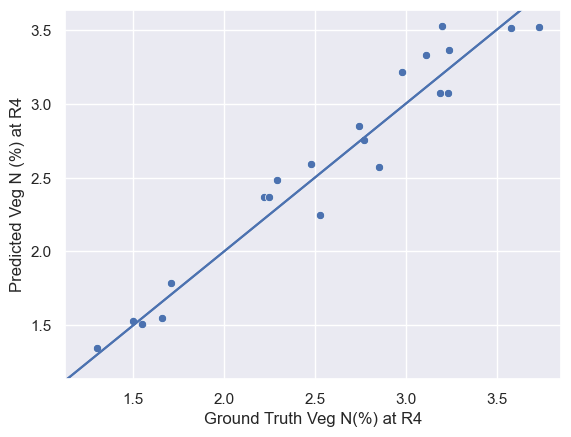

In [9]:
# SVR optimization function
def SVM_R(X, y):
    param_grid = {'kernel': ['linear', 'poly'],
                  'C': [0.1, 0.5, 1, 5, 10],
                }
    svr = SVR()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv = 3)
    grid_search.fit(X, y)
    best_svr = grid_search.best_estimator_
    return best_svr

# Train
svr = SVM_R(X =  X_train, y = y_train)
# Predict X_test values using trained SVR 
y_predict_svr = svr.predict(X_test)
r2 = r2_score(y_test, y_predict_svr)

# make a scatter plot of predictions 
sns.scatterplot(x = y_test, y = y_predict_svr.reshape(-1))
plt.axline((1.25, 1.25), slope = 1)
plt.xlabel('Ground Truth Veg N(%) at R4')
plt.ylabel('Predicted Veg N (%) at R4')
# This line represents perfect fit
plt.axline((1.25, 1.25), slope = 1)

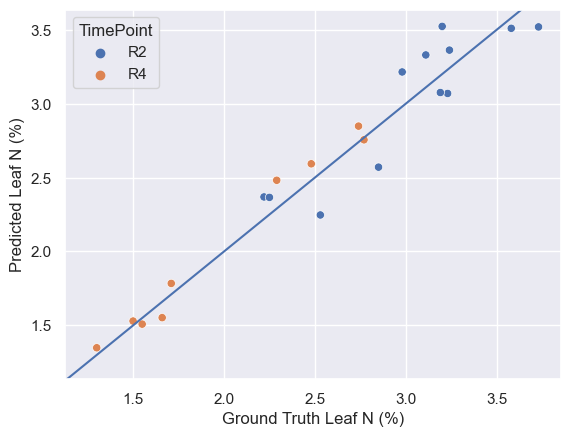

In [10]:
# We should know what the training and testing set looks like for this split
s = list(X_test.index)
test_df = modeldf.iloc[s, ]
y_pred_df = pd.Series(y_predict_svr, index=s, name='y_pred')
y_test_df = pd.Series(y_test, name = 'y_true')
ys = pd.merge(y_test_df, y_pred_df, right_index=True, left_index=True)
test_df = pd.merge(test_df, ys, right_index=True, left_index=True)


#custom_colors = {1585: 'orange', 1861: 'blue'}
# now we can make pretty color coded residual graphs
sns.scatterplot(x = 'y_true', y = 'y_pred', data = test_df, hue = 'TimePoint')
plt.xlabel('Ground Truth Leaf N (%)')
plt.ylabel('Predicted Leaf N (%)')

# This line represents perfect fit
plt.axline((1.25, 1.25), slope = 1)
#plt.savefig('Img2.jpg')

## Part 2 -
* Make new predictions
* Compare predicted vs true at R4 
* Calculate ReMob and do analysis of 5 hybrids with predicted vs true N values
    - If this is success then we should get the same groups from remob values

In [11]:
# Now lets make predictions for 44 new samples
# Features
X_new = slatedf.loc[:, predictors]
y_new = svr.predict(X_new)
# Fill in slatedf with new values
slatedf.loc[:, 'PredictedN'] = y_new

C:\Users\bdub\AppData\Local\Temp\ipykernel_1832\4058197999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slatedf.loc[:, 'PredictedN'] = y_new


<Axes: xlabel='NTreatment', ylabel='N(%)'>

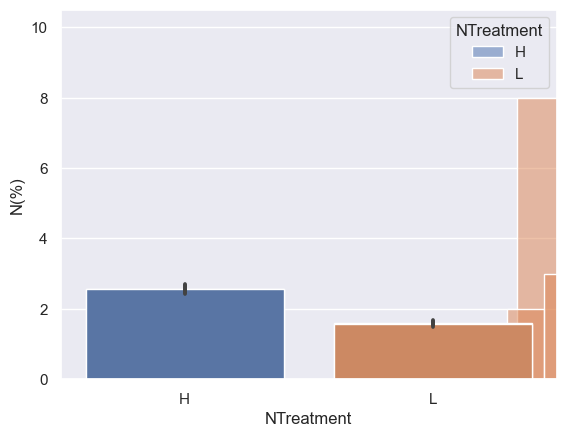

In [12]:
# Maybe make a panel of predictions vs ground truths
sns.histplot(data=slatedf, x ='PredictedN', hue = 'NTreatment', bins = 10)
sns.histplot(data=df1861, x ='N(%)', hue = 'NTreatment', bins=10)
sns.barplot(data=slatedf, x = 'NTreatment', y = 'PredictedN')
sns.barplot(data=df1861, x = 'NTreatment', y = 'N(%)')

In [13]:
# Make predictions for all 1861 
# Now lets make predictions for 44 new samples
# Features
X_new = df1861.loc[:, predictors]
y_new = svr.predict(X_new)
# Fill in slatedf with new values
df1861.loc[:, 'PredictedN'] = y_new

In [14]:
# A paired t-test suggests that there is no difference between predicted and actual N
pg.ttest(x = df1861['N(%)'], y = df1861['PredictedN'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.983548,19,two-sided,0.337697,"[-0.11, 0.04]",0.060907,0.356,0.057713


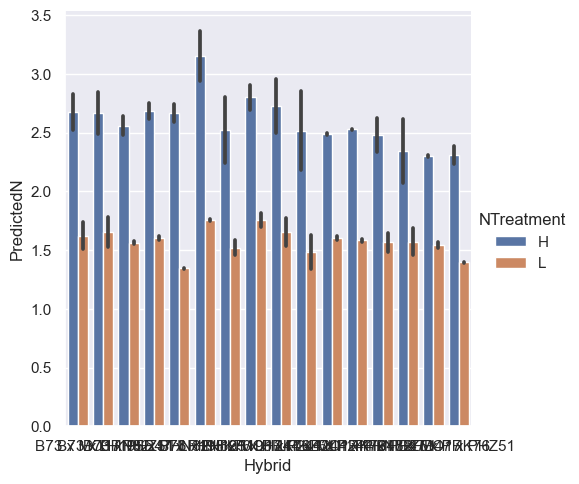

In [15]:
sns.catplot(data= df1861, x = 'Hybrid', y ='PredictedN', hue='NTreatment', kind = 'bar')

<Axes: xlabel='PredictedN', ylabel='Count'>

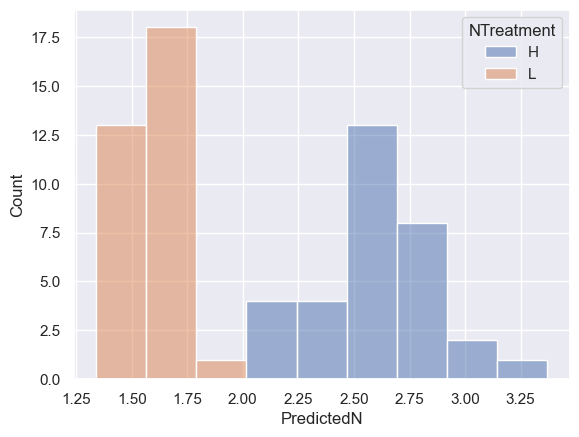

In [16]:
sns.histplot(data = df1861, x ='PredictedN', hue = 'NTreatment', bins = 9)

In [17]:
# Calc remobilized N for the 5 hybrids 
# 1. Append predicted N to df_field (2020 only with R2 info)
# 2. subset 3 hybrids that not in train set only - calc Remobilized N_pred as (R2 - Pred_N) / R2
# 3. Run remob analysis on Remo_NPred same as RemoteSensingForNV2

In [18]:
df1861a = df1861.loc[: , ['Plot', 'PredictedN']]
df_field = pd.merge(df_field, df1861a, on = 'Plot')
df_field.loc[:, 'NRemob_Pred'] = ((df_field['R2LeafN'] - df_field['PredictedN']) / df_field['R2LeafN'] * 100)
hyb_to_keep = ['B73 x PHN82', 'B73 x PHZ51', 'PHB47 x PHN82']
df_fielda = df_field.loc[df_field['Hybrid'].isin(hyb_to_keep), :]
#df_fielda.loc[:, 'NRemob_Pred'] = ((df_fielda['R2LeafN'] - df_fielda['PredictedN']) / df_fielda['R2LeafN'] * 100)


In [19]:
pg.ttest(x = df_fielda['NReMo'], y = df_fielda['NRemob_Pred'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.980052,11,two-sided,0.073263,"[-0.19, 3.69]",0.190192,1.243,0.092604


(array([0, 1, 2]),
 [Text(0, 0, 'B73 x PHN82'),
  Text(1, 0, 'B73 x PHZ51'),
  Text(2, 0, 'PHB47 x PHN82')])

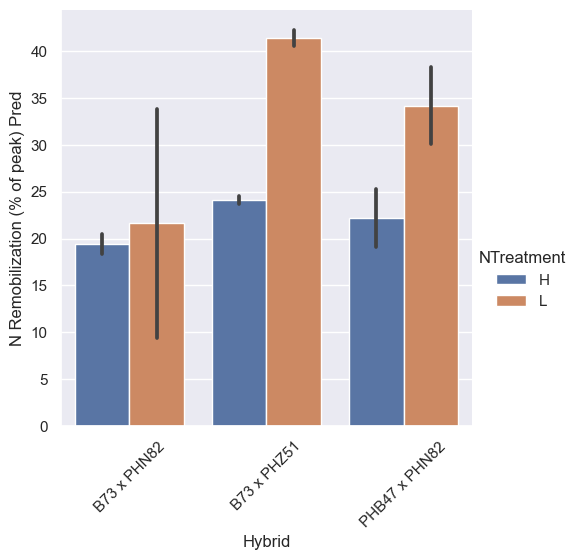

In [20]:
sns.catplot(data= df_fielda, x = 'Hybrid', y ='NRemob_Pred', hue='NTreatment', kind = 'bar')
plt.ylabel('N Remobilization (% of peak) Pred')
plt.xticks(rotation =45)
#plt.savefig('N_ReMo.pdf')

(array([0, 1, 2]),
 [Text(0, 0, 'B73 x PHN82'),
  Text(1, 0, 'B73 x PHZ51'),
  Text(2, 0, 'PHB47 x PHN82')])

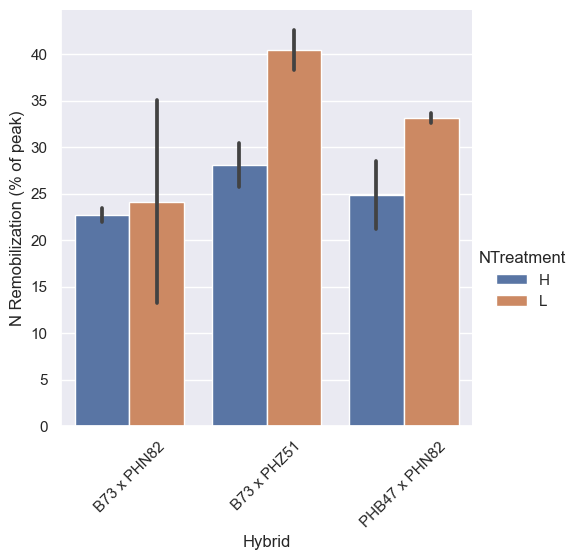

In [21]:
sns.catplot(data= df_fielda, x = 'Hybrid', y ='NReMo', hue='NTreatment', kind = 'bar')
plt.ylabel('N Remobilization (% of peak)')
plt.xticks(rotation =45)
#plt.savefig('N_ReMo.pdf')

In [22]:
pg.anova(data=df_fielda, dv = 'NRemob_Pred', between=['Hybrid', 'NTreatment'], ss_type = 'III')

,Source,SS,DF,MS,F,p-unc,np2
0,Hybrid,307.034746,2,153.517373,2.611028,0.152840,0.465339
1,NTreatment,330.963144,1,330.963144,5.629030,0.055327,0.484050
2,Hybrid * NTreatment,117.154530,2,58.577265,0.996284,0.423053,0.249303
3,Residual,352.774618,6,58.795770,NaN,NaN,NaN


In [23]:
pg.anova(data=df_fielda, dv = 'NReMo', between=['Hybrid', 'NTreatment'], ss_type = 'III')

,Source,SS,DF,MS,F,p-unc,np2
0,Hybrid,235.038009,2,117.519004,2.451154,0.166686,0.449658
1,NTreatment,162.506144,1,162.506144,3.389474,0.115210,0.360987
2,Hybrid * NTreatment,61.606738,2,30.803369,0.642482,0.558691,0.176386
3,Residual,287.666103,6,47.944350,NaN,NaN,NaN


## Running analysis with all 16 hybrids


<Figure size 2000x800 with 0 Axes>

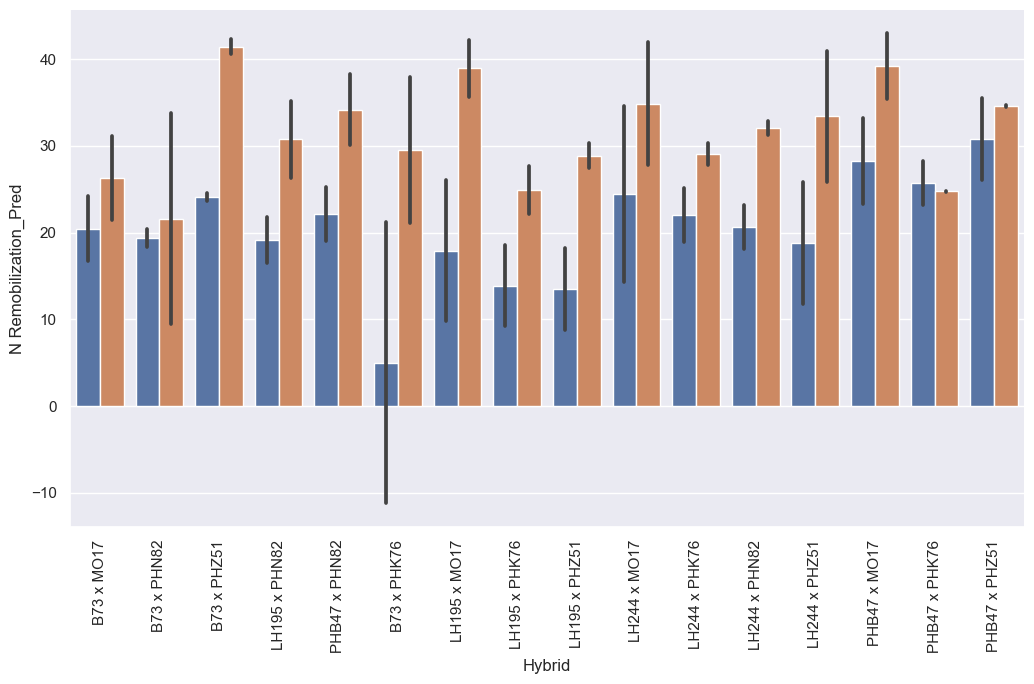

In [24]:
plt.figure(figsize=(20,8))
sns.catplot(data= df_field, x = 'Hybrid', y ='NRemob_Pred', hue='NTreatment', kind = 'bar', legend=False, height = 7, aspect = 1.5)
plt.ylabel('N Remobilization_Pred')
plt.xticks(rotation = 90)
plt.tight_layout()
#plt.savefig('N_ReMo_Pred.pdf')

In [25]:
# I think we should remove B73 x PHK76 because of outlier so jsut 15 hybrids now
df_field = df_field.loc[df_field['Hybrid'] != 'B73 x PHK76', :]

In [26]:
pg.anova(data=df_field, dv = 'NRemob_Pred', between=['Hybrid', 'NTreatment'], ss_type = 'III')

,Source,SS,DF,MS,F,p-unc,np2
0,Hybrid,1104.152684,14,78.868049,1.648095,0.122535,0.434744
1,NTreatment,1573.273988,1,1573.273988,32.876495,0.000003,0.522874
2,Hybrid * NTreatment,480.173348,14,34.298096,0.716723,0.741363,0.250639
3,Residual,1435.622009,30,47.854067,NaN,NaN,NaN


In [27]:
# how do predicted N remob and yield associate?
Corr_H_Pred = df_field.loc[df_field['NTreatment'] == 'H', ['NRemob_Pred', 'AdjustedYield15.5']].corr().iloc[0,1]
Corr_L_Pred = df_field.loc[df_field['NTreatment'] == 'L', ['NRemob_Pred', 'AdjustedYield15.5']].corr().iloc[0,1]
# Plants in low N remobilizing has no affect on yield but in High N remob is expensive

In [28]:
# We can now detect a difference in association between remob in H and L treatments so the best way to show is that is with a bar plot perhaps
df_field5H = df_field.loc[df_field['5HybridCode'] == 1, :]
Corr_H_Ground = df_field.loc[df_field['NTreatment'] == 'H', ['NReMo', 'AdjustedYield15.5']].corr().iloc[0,1]
Corr_L_Ground = df_field.loc[df_field['NTreatment'] == 'L', ['NReMo', 'AdjustedYield15.5']].corr().iloc[0,1]


In [29]:
df_corr = pd.DataFrame({'Method': ['Prediction' ,'Prediction', 'Ground', 'Ground'],
                        'Treatment': ['High', 'Low', 'High', 'Low'],
                        'YieldCorr':[Corr_H_Pred, Corr_L_Pred, Corr_H_Ground, Corr_L_Ground]})

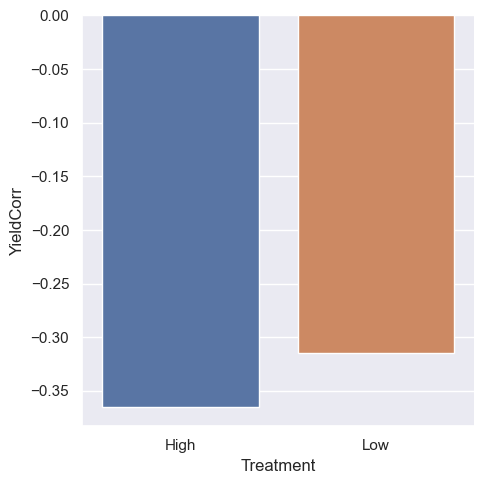

In [30]:
sns.catplot(data=df_corr.loc[df_corr['Method'] == 'Ground'], x = 'Treatment', y = 'YieldCorr', kind = 'bar')

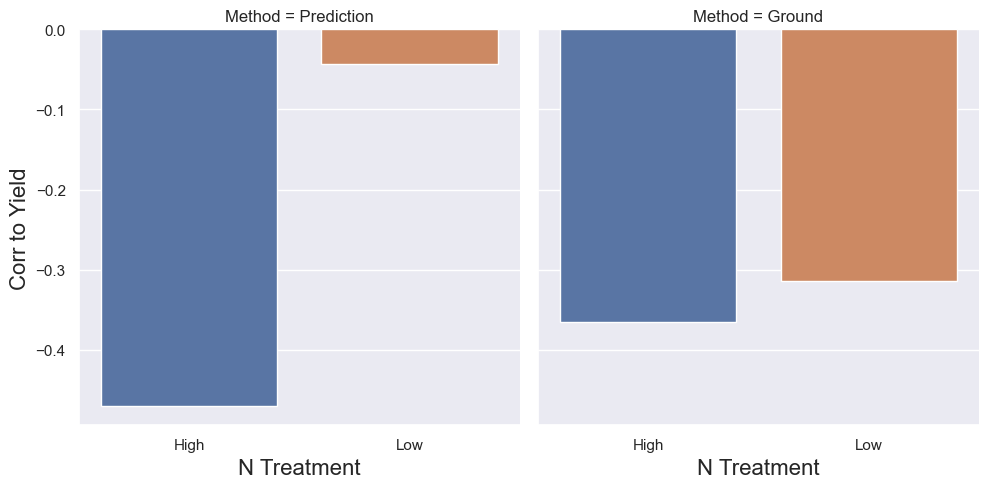

In [31]:
g = sns.catplot(data=df_corr, x = 'Treatment', y = 'YieldCorr', col = 'Method', kind = 'bar')
g.set_axis_labels('N Treatment', 'Corr to Yield', fontsize = 16)
plt.show()

In [32]:
# Do we think that there is a relationship now between NRemo and ndvi?
# In 5 hybrids the corr coeffienct is 0.

In [33]:
# Get just NReMo and Plot from df_field then merge with df_npcr
df_t = df_field.loc[:, ['Plot', 'NRemob_Pred']]
df_npcr = pd.merge(df_npcr, df_t, on = 'Plot')

982
1120
1265
1485
1585
1861
2210


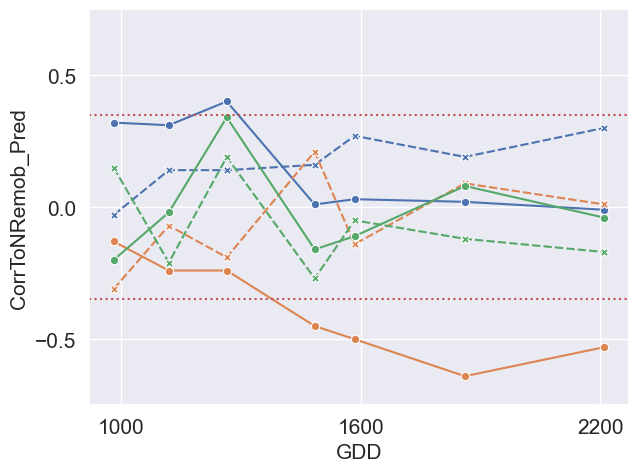

In [35]:
# Create a line graph of the corr of PCT90, STD, and ndvi with yield over time
tps = [982, 1120, 1265, 1485, 1585, 1861, 2210]
df = pd.DataFrame()
for tp in tps:
    print(tp)
    df_tp = df_npcr[df_npcr['GDD'] == tp]
    corr_tp_H = df_tp.loc[df_tp['NTreatment'] == 'H', ['NRemob_Pred', 'PCT90','STD', 'NDVI']]
    corr_tp_H = corr_tp_H.corr('spearman').round(2)
    corr_tp_H = corr_tp_H.iloc[[0],:]
    corr_tp_H['GDD'] = tp
    corr_tp_H['NTreatment'] = 'H'
    corr_tp_L = df_tp.loc[df_tp['NTreatment'] == 'L', ['NRemob_Pred', 'PCT90','STD', 'NDVI']]
    corr_tp_L = corr_tp_L.corr('spearman').round(2)
    corr_tp_L = corr_tp_L.iloc[[0],:]
    corr_tp_L['GDD'] = tp
    corr_tp_L['NTreatment'] = 'L'
    df = pd.concat([df, corr_tp_H])
    df = pd.concat([df, corr_tp_L])

# clean df
df = df.iloc[:, 1:]
df = pd.melt(df, id_vars=['GDD', 'NTreatment'], value_vars=['PCT90', 'NDVI', 'STD'], var_name='Trait', value_name='CorrToNRemob_Pred')

# make plot with new corr df over time
sns.lineplot(data = df, x = 'GDD', y='CorrToNRemob_Pred', hue = 'Trait', style='NTreatment', markers=True)
# critical value for 32 -2 = 30 df = 0.349 and alpha 0.05
plt.axhline(0.349, color = 'r', linestyle = ':')
plt.axhline(-0.349, color = 'r', linestyle = ':')
plt.ylim([-0.75, 0.75])
plt.tight_layout()
plt.xticks([1000, 1600, 2200], fontsize =15)
plt.xlabel('GDD', fontsize =15)
plt.yticks([-0.5, 0, 0.5], fontsize = 15)
plt.ylabel('CorrToNRemob_Pred', fontsize=15)
plt.legend(fontsize=12, loc='lower center', ncol=5).set_visible(False)
#plt.savefig('CorrToNRemob_Pred.pdf')
